In [1]:
# Load required python libraries

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

In [2]:
from astropy.io import fits

In [3]:
df = pd.read_csv('time_domain_features.csv')

In [4]:
df

,obi,obsid,region_id,src_cnts_aper_b,cnts_aper_b,ra,dec,var_prob_b,var_prob_h,var_prob_m,...,hard_hs,hard_ms,flux_significance_b,flux_significance_h,flux_significance_m,flux_significance_s,flux_aper_b,flux_aper_h,flux_aper_m,flux_aper_s
0,0,3904,108,199.930267,274,11.276413,-73.015666,0.154119,0.371614,0.068577,...,-0.066209,0.042473,10.447263,4.555556,7.958943,5.235294,2.379848e-14,1.178519e-14,7.671868e-15,4.860946e-15
1,1,11821,21,170.735756,173,15.466090,-72.685922,0.285792,NaN,NaN,...,0.825734,0.452217,10.853260,9.486466,5.599190,1.846154,1.240855e-13,1.151021e-13,1.132113e-14,0.000000e+00
2,1,2758,139,136.312266,221,15.852754,-72.526666,0.078909,0.185616,0.262795,...,0.154903,-0.152405,7.444890,4.270270,5.028571,3.696970,5.552476e-14,4.781359e-14,5.653946e-15,3.055563e-15
3,1,11821,19,133.141090,132,15.863378,-72.707469,0.078173,0.333268,0.231596,...,-0.317302,-0.321049,10.095118,4.666667,5.715805,6.474921,3.088066e-14,1.578454e-14,6.853366e-15,8.518044e-15
4,0,5146,9002,190.259152,82,16.569625,-72.092152,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.680709e-13,0.000000e+00,3.381479e-14,1.566023e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25994,1,2540,181,191.584142,181,100.262998,9.595849,0.140819,0.086044,0.128151,...,0.903186,0.622111,12.009054,10.374331,5.643965,2.000000,2.870943e-14,2.633167e-14,2.674511e-15,2.467159e-16
25995,0,11230,36,163.378079,229,346.142147,12.457685,0.080214,0.293756,0.267520,...,-0.206121,-0.097439,9.633195,4.105263,7.593484,5.470588,3.406833e-14,0.000000e+00,1.903885e-14,1.717000e-14
25996,0,16120,25,170.808472,158,61.361403,38.100872,0.072514,0.077052,0.316251,...,0.717052,0.433479,10.843980,8.871762,6.378816,2.631579,2.801847e-14,2.413415e-14,3.763270e-15,5.648770e-16
25997,0,5424,117,111.391011,107,13.154001,56.587583,0.785903,0.403860,0.593103,...,-0.327295,-0.296065,9.174260,4.722222,5.628702,5.556577,1.526129e-14,8.493587e-15,3.527627e-15,3.493036e-15


In [5]:
def times_to_lags(T):
    """(N x n_step) matrix of times -> (N x n_step) matrix of lags.
    First time is assumed to be zero.
    """
    assert T.ndim == 1, "T must be an (N x n_step) matrix"
    return np.concatenate([np.diff(T, axis=0), np.zeros(1)])

In [6]:
df[(df['obsid']==3904) & (df['region_id']==108)]

,obi,obsid,region_id,src_cnts_aper_b,cnts_aper_b,ra,dec,var_prob_b,var_prob_h,var_prob_m,...,hard_hs,hard_ms,flux_significance_b,flux_significance_h,flux_significance_m,flux_significance_s,flux_aper_b,flux_aper_h,flux_aper_m,flux_aper_s
0,0,3904,108,199.930267,274,11.276413,-73.015666,0.154119,0.371614,0.068577,...,-0.066209,0.042473,10.447263,4.555556,7.958943,5.235294,2.379848e-14,1.178519e-14,7.671868e-15,4.860946e-15


In [7]:
X = []
Y = []
lags = []
energies = []
for file in glob.glob('/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/*regevt*gz'):
    print(file)
    #print(file.split('_')[2][-5:],file.split('_')[4][-4:])
    hdul = fits.open(file)
    times = hdul[1].data['time']
    lag1 = times_to_lags(times)[np.where((hdul[1].data['grade']>0) & (hdul[1].data['pha']>40) & (hdul[1].data['energy']>500) & (hdul[1].data['energy']<7000))]
    ene1 = hdul[1].data['energy'][np.where((hdul[1].data['grade']>0) & (hdul[1].data['pha']>40) & (hdul[1].data['energy']>500) & (hdul[1].data['energy']<7000))]
    lags.append(lag1)
    energies.append(ene1)
    #print(np.shape(np.concatenate(([lag1],[ene1]))))
    X.append((np.concatenate(([lag1],[ene1]))))
    #X.append(np.concatenate(np.array(lag1),np.array(ene1)))
    var_b = df[(df['obsid']==int(file.split('_')[2][-5:])) & (df['region_id']==int(file.split('_')[4][-4:]))]['var_prob_b']
    var_h = df[(df['obsid']==int(file.split('_')[2][-5:])) & (df['region_id']==int(file.split('_')[4][-4:]))]['var_prob_h']
    var_m = df[(df['obsid']==int(file.split('_')[2][-5:])) & (df['region_id']==int(file.split('_')[4][-4:]))]['var_prob_m']
    var_s = df[(df['obsid']==int(file.split('_')[2][-5:])) & (df['region_id']==int(file.split('_')[4][-4:]))]['var_prob_s']
    Y.append(np.concatenate((var_b,var_h,var_m,var_h)))

/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf09334_000N021_r0015_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf06401_000N020_r0012_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf04987_000N020_r0004_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf00915_000N020_r0038_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf13789_000N020_r0031_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf13485_000N020_r0008_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf13498_000N020_r0113_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_autoencoder/data/cdapackage.183.20210213.103854/acisf05609_001N020_r0043_regevt3.fits.gz
/Users/juan/L3/ml_prototype/rnn_

In [11]:
X_aux = []
for i in range(len(X)):
    X_aux.append(X[i].T)

In [13]:
Y[0]

array([0.07569196, 0.29330936, 0.4523476 , 0.29330936])

In [14]:
X = X_aux

In [15]:
#np.savez('training_data_rnn.npy', X, Y)

<ipython-input-23-ba07366c4e17>:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,200)


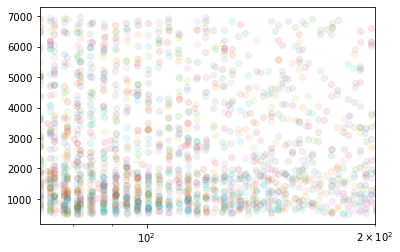

In [23]:
for i in range(200,300):
    #plt.subplots(2,1)
    #plt.subplot(2,1,1)
    #plt.hist(lags[i],alpha=0.5,bins=30)
    #plt.subplot(2,1,2)
    #plt.hist(energies[i],bins=30)
    #print(lags[i][0:100])
    #print(len(lags[i]),len(energies[i]))
    plt.scatter(lags[i], energies[i],alpha=0.1)
    plt.xlim(0,200)
    plt.xscale('log')

In [6]:
n_evts = []
for i in range(len(lags)):
    n_evts.append(len(lags[i]))

3206


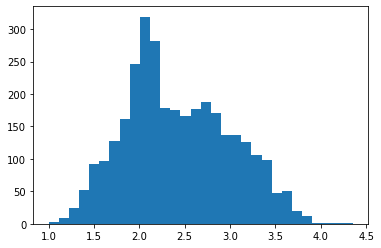

In [7]:
plt.hist(np.log10(n_evts),bins=30)
print(len(n_evts))

In [4]:
hdul.info()

Filename: acisf11591_000N020_r0017_regevt3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      79   ()      
  1  EVENTS        1 BinTableHDU   1178   126R x 19C   [1D, 1I, 1I, 1J, 1I, 1I, 1I, 1I, 1E, 1E, 1E, 1E, 1J, 1J, 1E, 1J, 1I, 1I, 32X]   
  2  GTI           7 BinTableHDU     33   1R x 2C   [1D, 1D]   
  3  GTI           5 BinTableHDU     33   1R x 2C   [1D, 1D]   
  4  GTI           6 BinTableHDU     33   1R x 2C   [1D, 1D]   
  5  GTI           3 BinTableHDU     33   2R x 2C   [1D, 1D]   
  6  GTI           2 BinTableHDU     33   2R x 2C   [1D, 1D]   
  7  MASK          1 ImageHDU        39   (34, 34)   uint8   


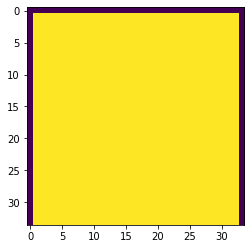

In [11]:
plt.imshow(hdul[7].data)

In [25]:
hdul[1].data.columns

ColDefs(
    name = 'time'; format = '1D'; unit = 's'
    name = 'ccd_id'; format = '1I'
    name = 'node_id'; format = '1I'
    name = 'expno'; format = '1J'
    name = 'chipx'; format = '1I'; unit = 'pixel'; coord_type = 'CPCX'; coord_unit = 'mm'; coord_ref_point = 0.5; coord_ref_value = 0.0; coord_inc = 0.023987
    name = 'chipy'; format = '1I'; unit = 'pixel'; coord_type = 'CPCY'; coord_unit = 'mm'; coord_ref_point = 0.5; coord_ref_value = 0.0; coord_inc = 0.023987
    name = 'tdetx'; format = '1I'; unit = 'pixel'
    name = 'tdety'; format = '1I'; unit = 'pixel'
    name = 'detx'; format = '1E'; unit = 'pixel'; coord_type = 'LONG-TAN'; coord_unit = 'deg'; coord_ref_point = 4096.5; coord_ref_value = 0.0; coord_inc = 0.00013666666666667
    name = 'dety'; format = '1E'; unit = 'pixel'; coord_type = 'NPOL-TAN'; coord_unit = 'deg'; coord_ref_point = 4096.5; coord_ref_value = 0.0; coord_inc = 0.00013666666666667
    name = 'x'; format = '1E'; unit = 'pixel'; coord_type = 'RA---TAN'; c

In [35]:
for i in range(len(hdul[1].data['time'])):
    print(hdul[1].data['time'][i],hdul[1].data['chipx'][i],hdul[1].data['chipy'][i],hdul[1].data['tdetx'][i],hdul[1].data['tdety'][i],
         hdul[1].data['detx'][i],hdul[1].data['dety'][i],hdul[1].data['x'][i],hdul[1].data['y'][i],hdul[1].data['pha'][i],
         hdul[1].data['pha_ro'][i],hdul[1].data['energy'][i],hdul[1].data['grade'][i])

366560345.61004627 154 629 4071 2331 4061.8257 3968.5686 4008.2861 4174.8994 1979 1914 8844.354 2
366561291.0585236 146 622 4063 2324 4053.7344 3975.6274 3998.226 4182.183 347 321 1571.2206 2
366561360.16104716 160 605 4077 2307 4067.3042 3992.5989 4003.228 4172.5835 2084 2015 9310.948 6
366561410.4174496 172 618 4089 2320 4079.6758 3979.9954 3985.4146 4172.56 2260 2217 10084.506 0
366561909.8403745 144 634 4061 2336 4051.6458 3963.6516 3998.113 4181.36 182 164 836.57764 2
366562355.8658769 154 630 4071 2332 4061.2676 3968.041 3998.072 4181.2505 450 413 2031.4457 3
366562415.5453399 159 638 4076 2340 4066.9753 3960.449 3997.8252 4181.4443 1043 990 4675.7305 6
366562874.1349329 147 610 4064 2312 4054.6343 3987.7068 3997.3286 4181.95 326 302 1478.279 2
366563031.1861707 125 643 4042 2345 4032.359 3955.411 3987.005 4198.488 3273 3191 14601.128 6
366563037.4682111 149 630 4066 2332 4056.3276 3967.8474 3989.1616 4170.943 2149 2090 9600.811 6
366563430.0963007 151 609 4068 2311 4058.1787 398